In [1]:
import os
import h5py
from scipy.stats import ttest_ind

import nexusformat.nexus as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from tqdm import tqdm
import glob


from eeg_prep.network import state_lds_array
from eeg_prep.preprocess.ieeg import preprocess_ieeg
from eeg_prep.utils import compute_samplepoints
from connection_complexity.data.raw_data.EDF.edf_helpers import read_edf
from eeg_prep.metrics.sourcesink import state_sourcesink_array

# f = nx.nxload("f:\\git\\eeg_prep\\me\\processed_files\\001_000500_000500.hdf5")
f = nx.nxload("/media/dan/Data/git/eeg_prep/processed_files/001_000500_000500.hdf5")
print(f.tree)

root:NXroot
  @date_created = '2024-10-03 16:02:40'
  @description = 'HDF5 file containing iEEG data and calculation...'
  data:NXgroup
    @description = 'windows are shaped (winsize_samps, len(channel...'
    A_mask = bool(609)
    A_mats = float64(118x118x609)
    A_mean = float64(118x118x1)
    A_medians = float64(609)
    A_thresh = 4.466130102425403
    window_indexs = int64(609x2)
    window_reconstructionError = float64(609)
    windows = float64(512x118x609)
  metadata:NXgroup
    N_samples = 312064
    N_wins = 609
    STEPSIZE_MSEC = 500
    STEPSIZE_SAMPS = 512
    WINSIZE_MSEC = 500
    WINSIZE_SAMPS = 512
    channels = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', '...
    patient_info:NXgroup
      aal = ['ParaHippocampal_R', 'Hippocampus_R', 'Hippocampus_R', ...
      aal2 = ['ParaHippocampal_R', 'Hippocampus_R', 'Hippocampus_R', ...
      age_days_at_recording = float64(118)
      age_years_at_recording = float64(118)
      bad_channel = ['False', 'False', 'F

In [2]:
hdf5_path = "F:\\git\\eeg_prep\\me\\processed_files"
hdf5_path = "/media/dan/Data/git/eeg_prep/processed_files"

files = os.listdir(hdf5_path)
    
# load all files into individual lists
channels = {}
ranks = {}
soz = {}
ilae = {}
pids = []
a_mats = {}

for f in tqdm(files):
    if f.endswith(".hdf5"):
        pid = int(f.split("_")[0])
        pids.append(pid)
        ranks[pid] = {}
        with h5py.File(os.path.join(hdf5_path,f), "r") as f:
            channels[pid] = f['metadata']["channels"][:]
            # convert from bytes to string
            channels[pid] = [x.decode('utf-8') for x in channels[pid]]

            soz[pid] = f['metadata']["patient_info"]['soz'][:]
            ilae[pid] = f['metadata']["patient_info"]['ilae'][:]

            ranks[pid]['ss_ind_mats'] = f['network']["mean_sinksource"]["ss_ind_mats"][:]
            ranks[pid]['source_infl_mats'] = f['network']["mean_sinksource"]["source_infl_mats"][:]
            ranks[pid]['source_dist_mats'] = f['network']["mean_sinksource"]["source_dist_mats"][:]
            ranks[pid]['sink_dist_mats'] = f['network']["mean_sinksource"]["sink_dist_mats"][:]
            ranks[pid]['sink_conn_mats'] = f['network']["mean_sinksource"]["sink_conn_mats"][:]


100%|██████████| 72/72 [00:00<00:00, 307.54it/s]


In [3]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

# Run and check that results are the same from load

In [4]:
def compute_A(
    raw,
    winsize_samps,
    stepsize_samps,
):
    # Compute the state-space model
    data = raw.get_data()

    A_mats = state_lds_array(
        data, winsize=winsize_samps, stepsize=stepsize_samps, l2penalty=0
    )

    # calculate the error of the A in reconstructing the data
    window_indexs = compute_samplepoints(winsize_samps, stepsize_samps, raw.n_times)
    channels = raw.ch_names
    # initialize windowed data
    n_wins = window_indexs.shape[0]
    windows = np.zeros((winsize_samps, len(channels), n_wins))
    errors = np.zeros(n_wins)
    for idx in range(n_wins):
        windows[:, :, idx] = data[:, window_indexs[idx, 0] : window_indexs[idx, 1]].T
        w = windows[:, :, idx]
        A = A_mats[..., idx]
        w_hat = np.dot(A, w.T).T
        errors[idx] = np.linalg.norm(w - w_hat)

    # filter bad A's based on median * 10 (arbitrary but our outliers are very large)
    A_medians = []
    for x in range(A_mats.shape[-1]):
        A_medians.append(np.median(np.abs(A_mats[..., x])))

    A_thresh = np.median(A_medians) * 100
    A_mask = []
    for x in range(A_mats.shape[-1]):
        if A_medians[x] > A_thresh:
            A_mask.append(False)
        else:
            A_mask.append(True) # keep good A's
    A_mask = np.array(A_mask)

    A_mean = np.mean(A_mats[..., A_mask], axis=-1, keepdims=True)
    return A_mats, A_medians, A_thresh, A_mask, A_mean, window_indexs, windows, errors


if os.name == "nt":
    edf_path = "F:\\data\\iEEG\\raw_ieeg\\baseline_patients\\baseline_edfs"
    output_path = "processed_files"
    mapping_path = "f:\\manuscripts\\manuiscript_0001_hfo_rates\\data\\FULL_composite_patient_info.csv"
    ilae_path = "c:\\Users\\wirel\\Downloads\\ravi_hfo_numbers~N59+v03.csv"
    bad_channels_path = (
        "F:\\manuscripts\\manuiscript_0001_hfo_rates\\data\\bad_ch_review.xlsx"
    )
else:
    edf_path = "/media/dan/Data/data/iEEG/raw_ieeg/baseline_patients/baseline_edfs"
    output_path = "processed_files"
    mapping_path = "/media/dan/Data/manuscripts/manuiscript_0001_hfo_rates/data/FULL_composite_patient_info.csv"
    ilae_path = "/media/dan/Data/manuscripts/manuiscript_0001_hfo_rates/ravi_hfo_numbers~N59+v03.csv"  
    bad_channels_path = "/media/dan/Data/manuscripts/manuiscript_0001_hfo_rates/data/bad_ch_review.xlsx"

edf_files = sorted(list(glob.glob(os.path.join(f"{edf_path}", "*.EDF"))))

# get metadata
mappings = pd.read_csv(mapping_path)
ilae1 = pd.read_csv(ilae_path)
bad_channels = pd.read_excel(bad_channels_path)
bad_channels["use"] = bad_channels["use"].fillna(1)
bad_channels["use2"] = bad_channels["use2"].fillna(1)
bad_channels["use"] = bad_channels["use"].astype(bool)
bad_channels["use2"] = bad_channels["use2"].astype(bool)

# OR bad_channel columns
bad_channels["bad_channel"] = ~(bad_channels["use"] & bad_channels["use2"])

# for each patient in mappings, find the corresponding ilae number. The patient may not be in the ilae dataset but has a designation of seizureFree or not.
# if the patient is not in the ilae dataset, then use the seizureFree column to determine the ilae number where -1 is seizureFree and 100 is not seizureFree
ilae_numbers = {}
for pid in mappings["pid"].unique():
    if pid in ilae1["patient"].values:
        ilae_numbers[pid] = ilae1[ilae1["patient"] == pid]["ilae"].values[0]
    else:
        if mappings[mappings["pid"] == pid]["seizureFree"].values[0] == True:
            ilae_numbers[pid] = -1
        else:
            ilae_numbers[pid] = 100

# now we have a dictionary of ilae numbers for each patient. Fill in the mappings dataframe with these numbers which has multiple rows for each patient
ilae_list = []
for pid in mappings["pid"]:
    ilae_list.append(ilae_numbers[pid])
mappings["ilae"] = ilae_list


# Perform the merge as before
mappings = mappings.merge(
    bad_channels[['pid', 'ch', 'bad_channel']],
    left_on=['pid', 'electrode'],
    right_on=['pid', 'ch'],
    how='left'
)

# Drop the 'ch' column if needed
mappings = mappings.drop(columns=['ch'])

# Fill NaN values in 'bad_channel' with 0
mappings['bad_channel'] = mappings['bad_channel'].fillna(0)


file = edf_files[0]
print(file)

WINSIZE_MSEC = 500
STEPSIZE_MSEC = 500

pid = int(os.path.basename(file).split("_")[0])

# get patient info
patient_info = mappings[mappings["pid"] == pid]

# ======== Process A and sourcesink ========
# load the raw data
raw = read_edf(file, preload=True)
raw.info["line_freq"] = 60

raw = preprocess_ieeg(raw)

# remove bad channels
raw = raw.drop_channels(patient_info[patient_info["bad_channel"] == 1]["electrode"].values)

# average reference
raw = raw.set_eeg_reference(ref_channels="average", projection=False, verbose=False)

sfreq = raw.info["sfreq"]

# round to nearest sample
winsize_samps = int(np.round(WINSIZE_MSEC * (sfreq / 1000)))
stepsize_samps = int(np.round(STEPSIZE_MSEC * (sfreq / 1000)))

# compute A
calculations = compute_A(raw, winsize_samps, stepsize_samps)
# A_mats = calculations[0]
A_mean = calculations[4]


(
ss_ind_mats,
source_dist_mats,
sink_dist_mats,
source_infl_mats,
sink_conn_mats,
_,
) = state_sourcesink_array(
A_mean,
return_all=True
)

/media/dan/Data/data/iEEG/raw_ieeg/baseline_patients/baseline_edfs/001_Baseline.EDF


In [5]:
my_dict = ranks[pid]

for key, value in my_dict.items():
    # Attempt to retrieve the variable from the global scope
    var = globals().get(key)
    
    if var is not None:
        if isinstance(var, np.ndarray):
            if np.allclose(var, value):
                print(f"Variable '{key}' is equal to the dictionary value.")
            else:
                print(f"Variable '{key}' is DIFFERENT from the dictionary value.")
        else:
            print(f"Variable '{key}' exists but is not a numpy array.")
    else:
        print(f"Variable '{key}' does NOT exist in the current scope.")


Variable 'ss_ind_mats' is equal to the dictionary value.
Variable 'source_infl_mats' is equal to the dictionary value.
Variable 'source_dist_mats' is equal to the dictionary value.
Variable 'sink_dist_mats' is equal to the dictionary value.
Variable 'sink_conn_mats' is equal to the dictionary value.


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_boxplot_with_pvals(df, x_col, y_col, hue_col, pvalues, hue_order=[0,1], figsize=(10, 5), y_text_pos=-0.04, ax=None,gap=.1, N=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    sax = sns.violinplot(data=df, x=x_col, y=y_col, hue=hue_col, hue_order=hue_order, ax=ax, cut=0, split=True, gap=gap, inner="quart")
    
     # Plot p-values
    sorted_dict = dict(sorted(pvalues.items(), key=lambda item: item[1]))
    for idx, (_, pval) in enumerate(sorted_dict.items()):
        sax.text(x=idx, y=y_text_pos, s=convert_pvalue_to_asterisks(pval), color='red', ha='center', va='center')

    # Draw a line between the medians of the two groups
    for idx, (group_name, group_data) in enumerate(df.groupby(x_col)):
        group_data = group_data.groupby(hue_col).median()
        if group_data.loc[0, y_col] < group_data.loc[1, y_col]:
            sax.plot([idx-0.1, idx+0.1], [group_data.loc[0, y_col], group_data.loc[1, y_col]], color='black')
        else:
            sax.plot([idx-0.1, idx+0.1], [group_data.loc[0, y_col], group_data.loc[1, y_col]], color='red')

    # place a dot at the mean of each group
    for idx, (group_name, group_data) in enumerate(df.groupby(x_col)):
        group_data = group_data.groupby(hue_col).mean()
        sax.plot(idx-0.1, group_data.loc[0, y_col], marker='o', color='m', markersize=3)
        sax.plot(idx+0.1, group_data.loc[1, y_col], marker='+', color='m', markersize=3)

    if N:
        # Calculate number of points for each group
        group_counts = df.groupby([x_col, hue_col]).size()
        # Determine the overall max y-value to place annotations consistently
        y = y_text_pos + 0.1

        # Adding the number of points at the global maximum violin value plus some offset
        for idx, (group_name, group_data) in enumerate(df.groupby(x_col)):
            for hue_val in hue_order:
                hue_group = group_data[group_data[hue_col] == hue_val]
                if not hue_group.empty:
                    # Get the number of points
                    count = group_counts.loc[group_name, hue_val]
                    # Adjust offset above the global max value
                    # if odd hue_values, shift the annotation to the left, if even to the right
                    s = 5
                    if hue_val % 2 == 0:
                        sax.text(x=idx-gap, y=y, s=f'{count}', color='black', ha='right', va='center', fontdict={'size': s})
                    else:
                        sax.text(x=idx+gap, y=y, s=f'{count}', color='black', ha='left', va='center', fontdict={'size': s})  

    sax.legend(loc='upper right', title=hue_col)

    return sax


In [7]:
# combine all data into a 4 dataframes (one for each "conn/rank" combination)

dfs = pd.DataFrame(columns=['pid', 'soz', 'ilae', 'ss_ind_mats', 'source_infl_mats', 'source_dist_mats', 'sink_dist_mats', 'sink_conn_mats'])
for pid in pids:
    # read columns and propigate values that are singular to all rows
    df = pd.DataFrame(columns=['pid', 'soz', 'ilae', 'ss_ind_mats', 'source_infl_mats', 'source_dist_mats', 'sink_dist_mats', 'sink_conn_mats'])
    l = len(ranks[pid]['ss_ind_mats'])
    df['pid'] = [pid] * l
    df['soz'] = soz[pid]
    df['ilae'] = ilae[pid]
    df['ss_ind_mats'] = ranks[pid]['ss_ind_mats']
    df['source_infl_mats'] = ranks[pid]['source_infl_mats']
    df['source_dist_mats'] = ranks[pid]['source_dist_mats']
    df['sink_dist_mats'] = ranks[pid]['sink_dist_mats']
    df['sink_conn_mats'] = ranks[pid]['sink_conn_mats']

    # make sure all types are numeric
    for col in df.columns:
        df[col] = pd.to_numeric(df[col])
    # explicity set soz to 0/1
    df['soz'] = df['soz'].astype(int)
    dfs = pd.concat([dfs, df], ignore_index=True)
        
        


In [8]:
# for each dataframe, perform a t-test on the *_mats columns grouping by ilae then soz with soz being the test variable
pvalues = {}

for col in ['ss_ind_mats', 'source_infl_mats', 'source_dist_mats', 'sink_dist_mats', 'sink_conn_mats']:
    pvalues[col] = {}
    df = dfs
    ilae = df['ilae'].unique()
    soz = df['soz'].unique()
    for ilae_val in ilae:
        ilae_df = df[df['ilae'] == ilae_val]
        for soz_val in soz:
            ttest = ttest_ind(ilae_df[ilae_df['soz'] == 0][col], ilae_df[ilae_df['soz'] == 1][col])
            pvalues[col][ilae_val] = ttest.pvalue


In [42]:
# plot the data
# make plots for each metric 'ss_ind_mats', 'source_infl_mats', 'source_dist_mats', 'sink_dist_mats', 'sink_conn_mats'
# for each plot do a 2x2 showing the different conn/rank combinations


# for col in ['ss_ind_mats', 'source_infl_mats', 'source_dist_mats', 'sink_dist_mats', 'sink_conn_mats']:
#     fig, axs = plt.subplots(2, 2, figsize=(20, 10))

#     for x,ax in zip([[True, True], [True, False], [False, True], [False, False]],axs.flatten()):
#         conn = x[0]
#         conn_rank = x[1]

#         ax = plot_boxplot_with_pvals(dfs[(conn,conn_rank)], 'ilae', col, 'soz', pvalues[(conn,conn_rank)][col], ax=ax)
#         ax.set_title(f"0 diagonal entries in ranking={conn_rank}\n0 diagonal entries in metrics={conn}")
#     plt.suptitle(f"{col} by ilae and soz")
#     plt.tight_layout()
#     plt.savefig(f"{col}.png")
#     plt.close()


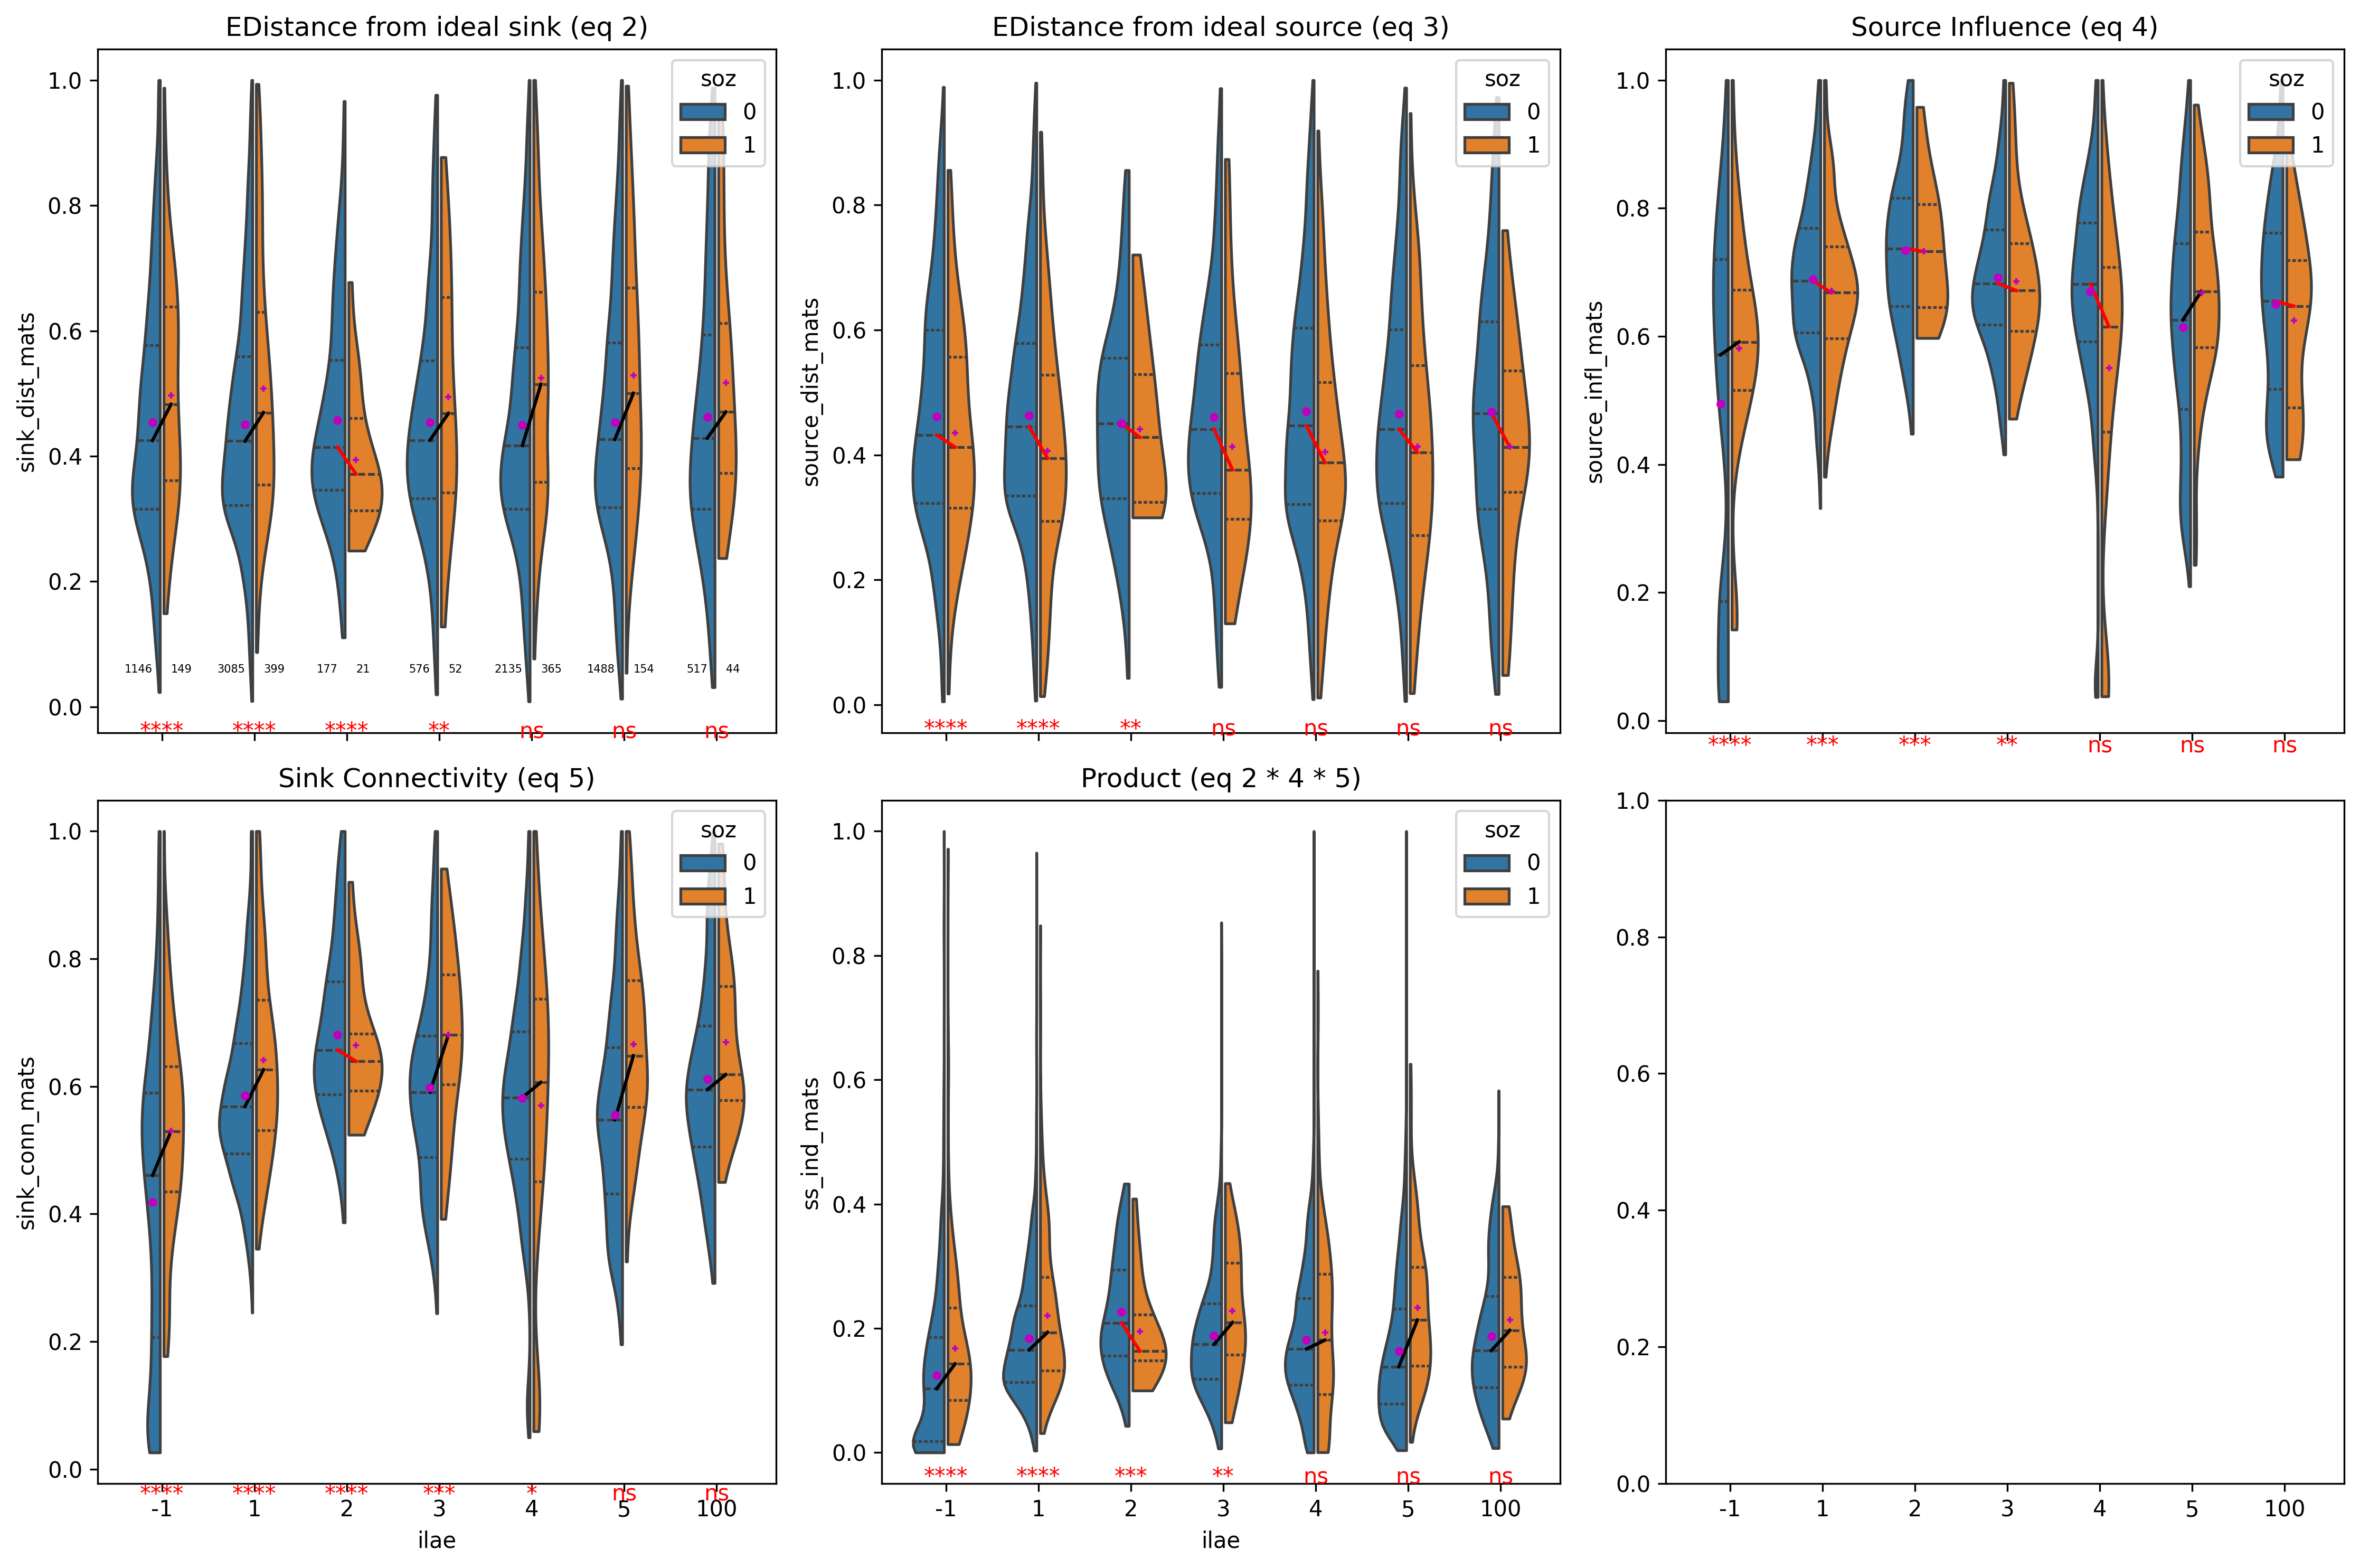

In [9]:
names = ["EDistance from ideal sink (eq 2)", "EDistance from ideal source (eq 3)", "Source Influence (eq 4)", "Sink Connectivity (eq 5)", "Product (eq 2 * 4 * 5)"]
# make 1 plot for true,true combination
fig, axs = plt.subplots(2,3, figsize=(15, 10),dpi=300,sharey=False,sharex=True)
axs = axs.flatten()
for i, col in enumerate(['sink_dist_mats', 'source_dist_mats', 'source_infl_mats',  'sink_conn_mats', 'ss_ind_mats']):
    name = names[i]
    if i == 0:
        N = True
    else:
        N = False
    ax = plot_boxplot_with_pvals(dfs, 'ilae', col, 'soz', pvalues[col], ax=axs[i], N=N)
    ax.set_title(name)
# plt.suptitle(f"True,True")
plt.tight_layout()
plt.savefig(f"SourceSink_Average.png",dpi=300)

In [43]:
dfs[(conn,conn_rank)][dfs[(conn,conn_rank)]['ilae'].isin([1,2,3,4,5,6])].to_csv("sourceSink_Data_v01.csv")

In [103]:
def check_string(x, s):
    if isinstance(x,str):
        if s in x.lower():
            return True
    return False

hippocampus_mask = []
for x,y in channels.items():
    pdf = mappings[mappings['pid'] == x]
    # remove any channels not in y from pdf
    pdf = pdf[pdf['electrode'].isin(y)]
    # sort electrode the same order as y
    pdf = pdf.set_index('electrode').loc[y].reset_index()

    aal_flag = pdf['aal'].apply(lambda x: check_string(x, 'hippocampus'))
    aal2_flag = pdf['aal2'].apply(lambda x: check_string(x, 'hippocampus'))
    brainnetome_flag = pdf['brainnetome'].apply(lambda x: check_string(x, 'hipp'))
    ho_flag = pdf['harvard-oxford'].apply(lambda x: check_string(x, 'hippocampus'))
    miccai_flag = pdf['miccai'].apply(lambda x: check_string(x, 'hippocampus'))
    flag = aal_flag | aal2_flag | brainnetome_flag | ho_flag | miccai_flag
    hippocampus_mask.extend(list(flag))
hippocampus_mask = ~np.array(hippocampus_mask) # invert the mask

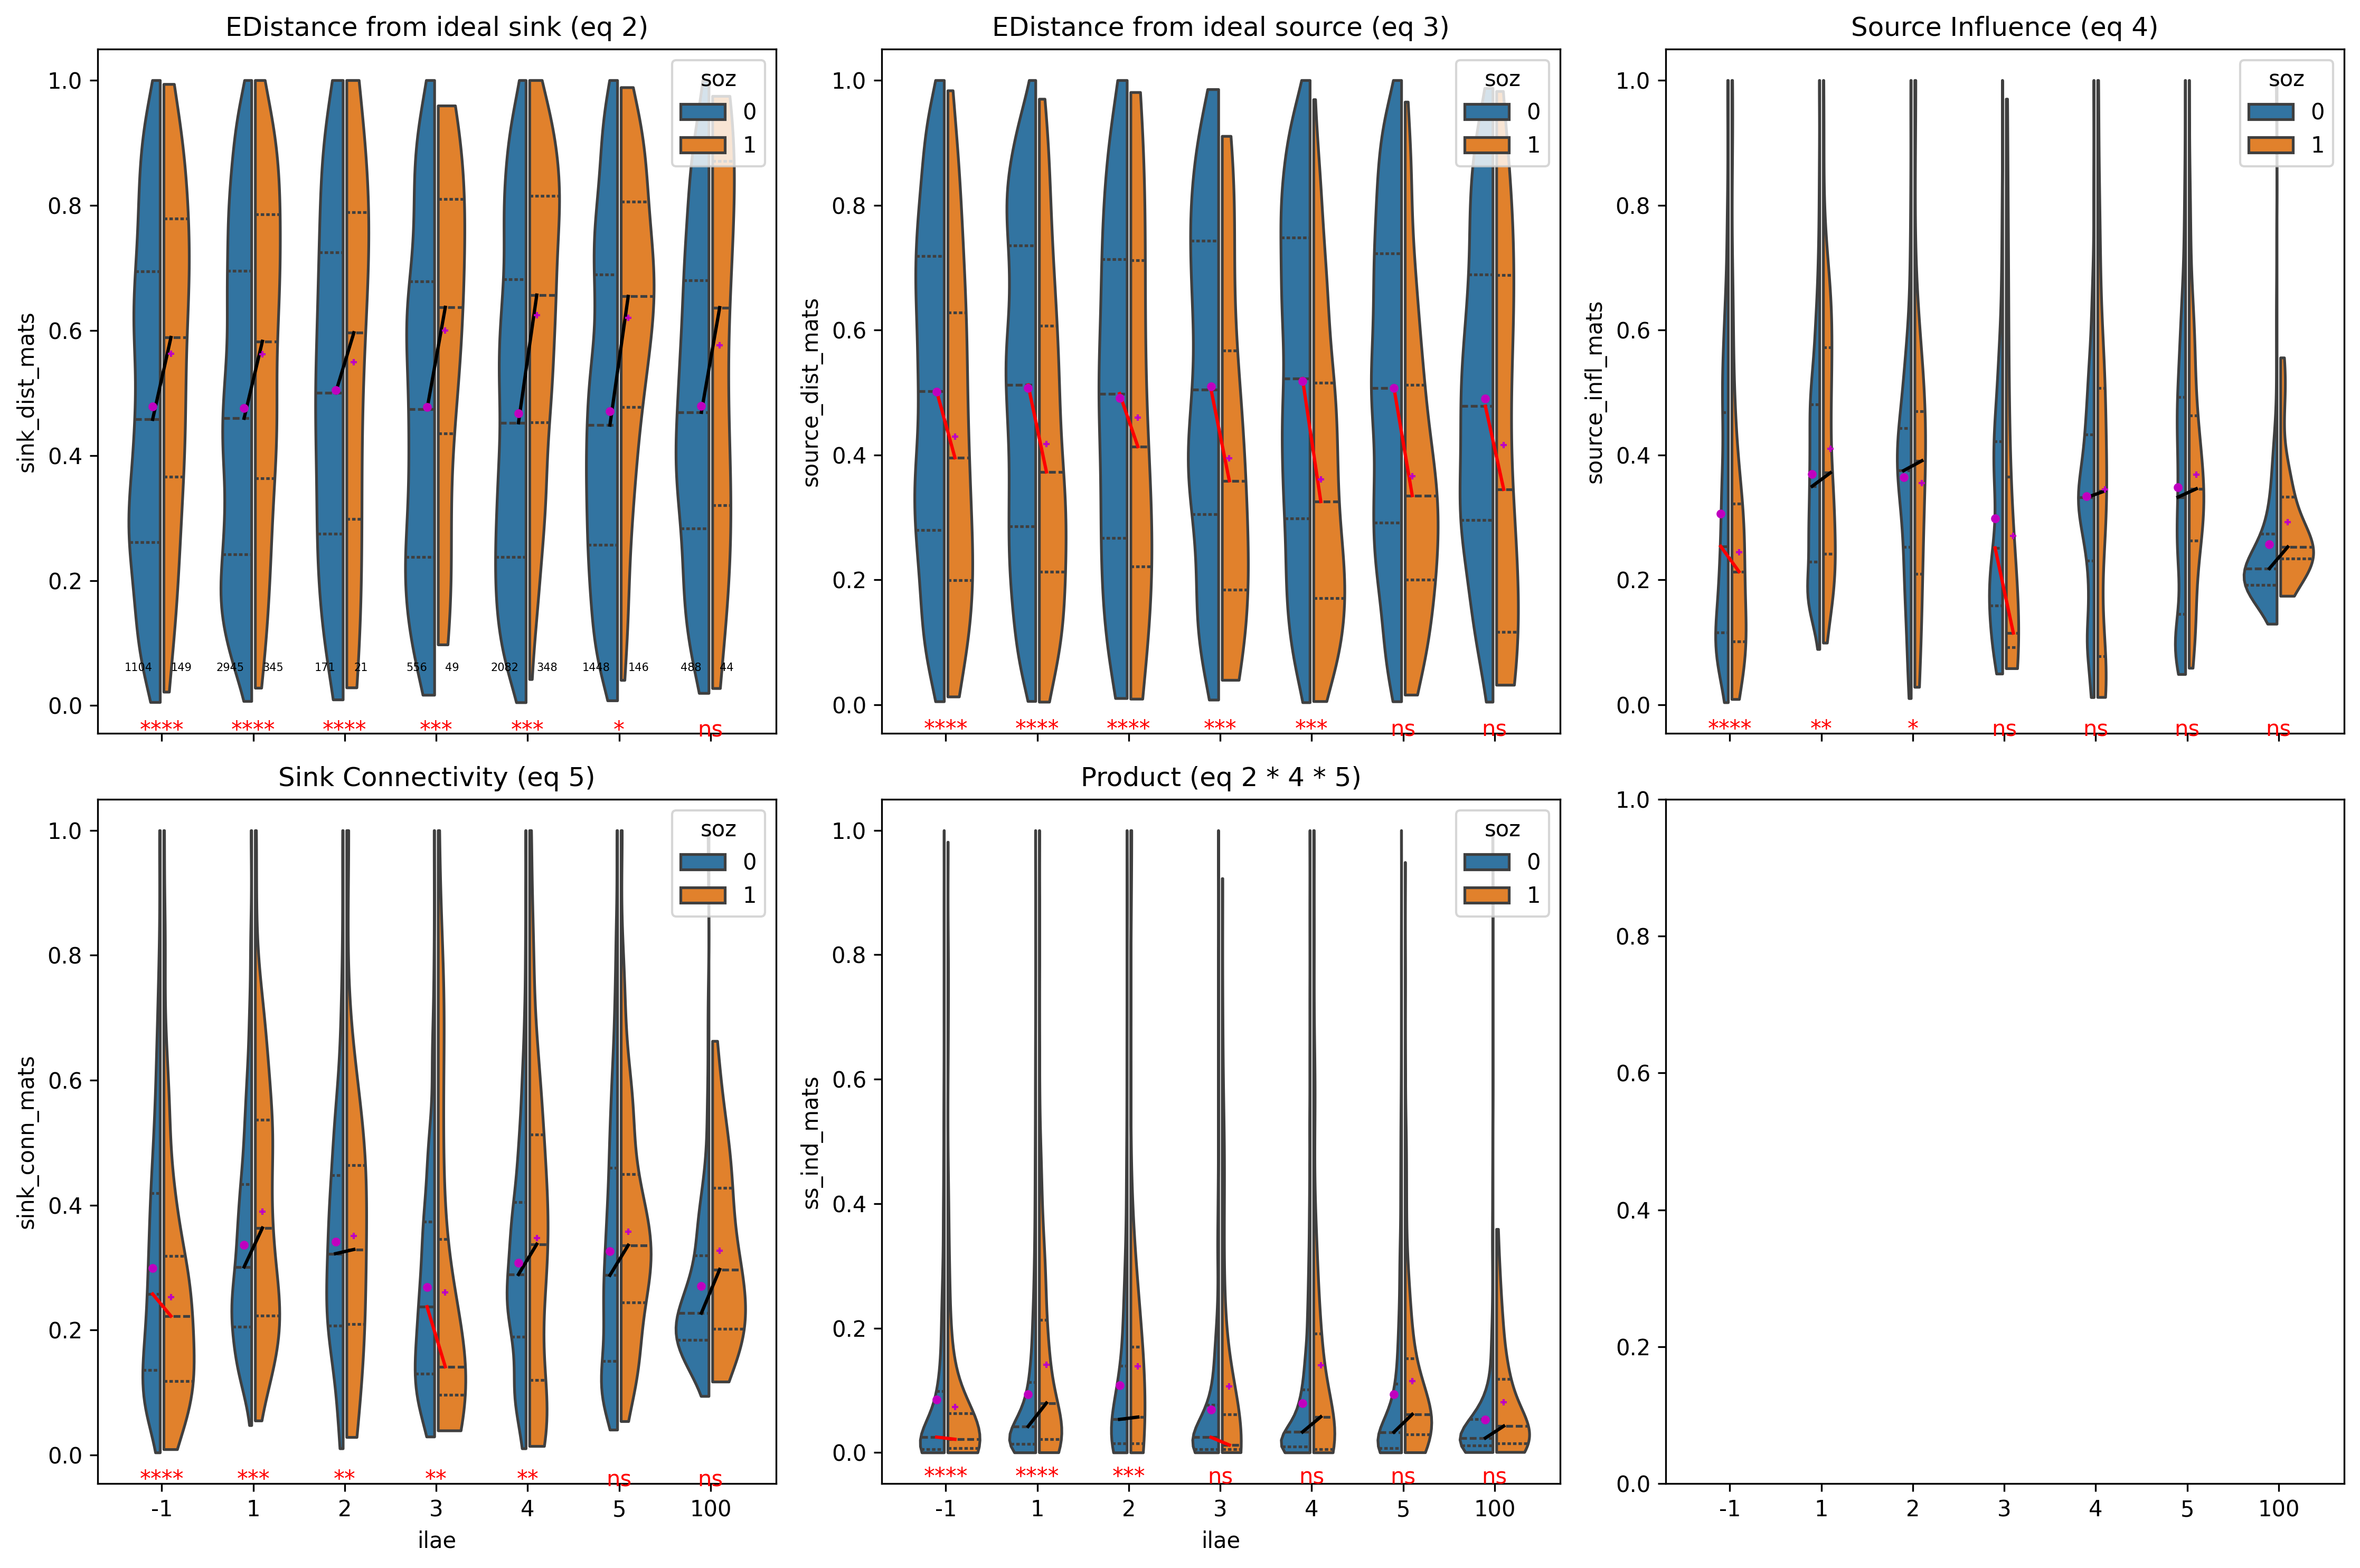

In [105]:
names = ["EDistance from ideal sink (eq 2)", "EDistance from ideal source (eq 3)", "Source Influence (eq 4)", "Sink Connectivity (eq 5)", "Product (eq 2 * 4 * 5)"]
# make 1 plot for true,true combination
fig, axs = plt.subplots(2,3, figsize=(15, 10),dpi=300,sharey=False,sharex=True)
axs = axs.flatten()
for i, col in enumerate(['sink_dist_mats', 'source_dist_mats', 'source_infl_mats',  'sink_conn_mats', 'ss_ind_mats']):
    name = names[i]
    if i == 0:
        N = True
    else:
        N = False
    ax = plot_boxplot_with_pvals(dfs[(True,False)][hippocampus_mask], 'ilae', col, 'soz', pvalues[(True,True)][col], ax=axs[i], N=N)
    ax.set_title(name)
# plt.suptitle(f"True,True")
plt.tight_layout()
plt.savefig(f"SourceSink_Average.png",dpi=300)